In [1]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sys
import time
from typing import Union
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf

sys.path.append(os.path.join('../', 'utils'))

from TransformationUtils import ExcelYAMLHandler
from TransformationUtils import StrategyCSVHandler

### Initial Set up

Make sure to assing fp_data_base to the input file of the country you are working on



In [2]:
##  SETUP DIRECTORIES

dir_cur = pathlib.Path(os.getcwd())
dir_data = dir_cur.joinpath("data")
dir_transformations = dir_cur.joinpath("transformations")


##  SETUP FILES: Edit the 

fp_data_base = dir_data.joinpath("sisepuede_inputs_croatia.csv")


##  SETUP SOME SISEPUEDE STUFF

file_struct = SISEPUEDEFileStructure()

matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

### Making sure our input file has the correct format and correct columns
We use an example df with the complete fields and correct format to make sure our file is in the right shape

In [3]:
##  BUILD BASE INPUTS

df_inputs_raw = pd.read_csv(fp_data_base)

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame

In [4]:
df_inputs_example.head()

,region,time_period,avgload_trns_freight_tonne_per_vehicle_aviation,avgload_trns_freight_tonne_per_vehicle_rail_freight,avgload_trns_freight_tonne_per_vehicle_road_heavy_freight,avgload_trns_freight_tonne_per_vehicle_water_borne,avgmass_lvst_animal_buffalo_kg,avgmass_lvst_animal_cattle_dairy_kg,avgmass_lvst_animal_cattle_nondairy_kg,avgmass_lvst_animal_chickens_kg,...,ef_ippu_tonne_cf4_per_tonne_production_electronics,ef_ippu_tonne_cf4_per_tonne_production_metals,ef_ippu_tonne_c3f8_per_tonne_production_chemicals,ef_ippu_tonne_c3f8_per_tonne_production_electronics,ef_ippu_tonne_c4f10_per_mmm_gdp_product_use_ods_other,ef_ippu_tonne_c4f10_per_tonne_production_chemicals,ef_ippu_tonne_c6f14_per_mmm_gdp_product_use_ods_other,ef_ippu_tonne_c6f14_per_tonne_production_chemicals,ef_ippu_tonne_cc4f8_per_tonne_production_chemicals,ef_ippu_tonne_cc4f8_per_tonne_production_electronics
0,costa_rica,0,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,4.204879e-07,0.0,1.515048e-07,0.0,0.0,0.0,0.0,0.0,5.669821e-08
1,costa_rica,1,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,2.134675e-07,0.0,1.313925e-07,0.0,0.0,0.0,0.0,0.0,5.185820e-08
2,costa_rica,2,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,1.821067e-07,0.0,1.060066e-07,0.0,0.0,0.0,0.0,0.0,5.269348e-08
3,costa_rica,3,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,2.094712e-07,0.0,1.093024e-07,0.0,0.0,0.0,0.0,0.0,5.500450e-08
4,costa_rica,4,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,3.446161e-07,0.0,1.046451e-07,0.0,0.0,0.0,0.0,0.0,5.266081e-08


In [5]:
# Some helpful functions to check differences between dataframes and fix them

def compare_dfs(df1, df2):
    # Assuming your DataFrames are df1 and df2
    columns_df1 = set(df1.columns)
    columns_df2 = set(df2.columns)

    # Columns present in df1 but not in df2
    diff_in_df1 = columns_df1 - columns_df2

    # Columns present in df2 but not in df1
    diff_in_df2 = columns_df2 - columns_df1

    print("Columns in df1 but not in df2:", diff_in_df1)
    print("Columns in df2 but not in df1:", diff_in_df2)

def add_missing_cols(df1, df2):
    # Identify columns in df1 but not in df2
    columns_to_add = [col for col in df1.columns if col not in df2.columns]

    # Add missing columns to df2 with their values from df1
    for col in columns_to_add:
        df2[col] = df1[col]
    
    return df2


In [6]:
# Checks if there are any differences in columns between the example df and our df
compare_dfs(df_inputs_example, df_inputs_raw)


Columns in df1 but not in df2: {'ratio_agrc_above_ground_residue_to_yield_pulses', 'regressionb_agrc_above_ground_residue_other_annual_kg_per_ha', 'ef_enfu_stationary_combustion_tonne_n2o_per_tj_fuel_furnace_gas', 'ef_enfu_combustion_tonne_co2_per_tj_fuel_gasoline', 'nemomod_entc_input_activity_ratio_fuel_production_fp_ammonia_production_electricity', 'ef_soil_ef1_n_rice_fields_n2o', 'physparam_lvst_bo_goats_kg_ch4_kg_manure', 'ef_soil_ef5_n_leaching_n2o', 'ef_enfu_stationary_combustion_tonne_n2o_per_tj_fuel_nuclear', 'frac_agrc_combustion_factor_other_annual', 'qty_soil_organic_c_stock_wet_climate_tonne_per_ha', 'nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_electricity', 'ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_hydrogen', 'ef_enfu_combustion_tonne_co2_per_tj_fuel_kerosene', 'frac_agrc_n_in_below_ground_residue_rice', 'ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_hydrocarbon_gas_liquids', 'physparam_lvst_bo_sheep_kg_ch4_kg_manure', 'e

In [7]:
# Fixes differences and makes sure that our df is in the correct format.
# Note: Edit this if you need more changes in your df

df_inputs_raw = df_inputs_raw.rename(columns={'period':'time_period'})
df_inputs_raw_complete = add_missing_cols(df_inputs_example, df_inputs_raw.copy())
df_inputs_raw_complete = df_inputs_raw_complete.drop(columns='iso_code3')
df_inputs_raw_complete.head()

,region,time_period,area_gnrl_country_ha,avgload_trns_freight_tonne_per_vehicle_aviation,avgload_trns_freight_tonne_per_vehicle_rail_freight,avgload_trns_freight_tonne_per_vehicle_road_heavy_freight,avgload_trns_freight_tonne_per_vehicle_water_borne,avgmass_lvst_animal_buffalo_kg,avgmass_lvst_animal_cattle_dairy_kg,avgmass_lvst_animal_cattle_nondairy_kg,...,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_electrolysis_water,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_electricity,energydensity_gravimetric_enfu_gj_per_tonne_fuel_ammonia,energydensity_gravimetric_enfu_gj_per_tonne_fuel_water,frac_trns_fuelmix_water_borne_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_ammonia_production_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_hydrogen,nemomod_entc_frac_min_share_production_fp_hydrogen_reformation_ccs,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_natural_gas,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_oil
0,croatia,0,8807000,70,2923,31.751466,6468,315,508,303,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
1,croatia,1,8807000,70,2923,31.751466,6468,315,508,303,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
2,croatia,2,8807000,70,2923,31.751466,6468,315,508,303,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
3,croatia,3,8807000,70,2923,31.751466,6468,315,508,303,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
4,croatia,4,8807000,70,2923,31.751466,6468,315,508,303,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0


In [8]:
# Double checking that our df is in the correct shape
compare_dfs(df_inputs_example, df_inputs_raw_complete)

Columns in df1 but not in df2: set()
Columns in df2 but not in df1: set()


In [9]:
# Checking if there are any columns with null values in it
columns_with_na = df_inputs_raw_complete.columns[df_inputs_raw_complete.isna().any()].tolist()

print(columns_with_na)

[]


#  Let's try building transformations using this


In [11]:
transformers = trf.transformers.Transformers(
    {},
    df_input = df_inputs_raw_complete,
)


##  Instantiate some transformations CAREFUL NOT TO OVERWRITE EXISTING TRANSFORMATIONS!!

In [12]:
# set an ouput path and instantiate
if not dir_transformations.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        dir_transformations,
    )


##  --HERE, CUSTOMIZE YOUR TRANSFORMATIONS AND STRATEGIES--
- go to `dir_transformers` and edit config files and `strategy_definitions.csv`
- then, go to next cell

### Customizing transformations and strategies files using TransformationUtils.py classes

In [13]:
# Generate new transformation files based on the excel mapping file. Change the excel file path for yours
excel_yaml_handler = ExcelYAMLHandler(excel_file='data/ssp_croatia_transformation_cw_vf.xlsx', yaml_directory='transformations')

In [14]:
excel_yaml_handler.process_yaml_files()

YAML file transformation_agrc_inc_conservation_agriculture.yaml for strategy strategy_current_measures set to default because it does not have magnitude attribute
YAML file transformation_agrc_inc_conservation_agriculture.yaml for strategy strategy_ndc set to default because it does not have magnitude attribute
YAML file transformation_agrc_inc_conservation_agriculture.yaml for strategy strategy_additional_actions set to default because it does not have magnitude attribute
YAML file transformation_inen_shift_fuel_heat.yaml for strategy strategy_additional_actions set to default because it does not have magnitude attribute
YAML file transformation_lsmm_inc_management_cattle_pigs.yaml for strategy strategy_current_measures set to default because it does not have magnitude attribute
YAML file transformation_lsmm_inc_management_cattle_pigs.yaml for strategy strategy_ndc set to default because it does not have magnitude attribute
YAML file transformation_lsmm_inc_management_cattle_pigs.yaml

In [15]:
# Creating new strategies by updating the strategy_definitions file.
# You can edit this to add yours, as many as you want.

csv_handler = StrategyCSVHandler('transformations/strategy_definitions.csv', 'transformations', '../utils/strategy_mapping.yaml')
csv_handler.add_row('PFLO', 'Croatia current measures', 'current_measures')
csv_handler.add_row('PFLO', 'Croatia ndc commitments', 'ndc')
csv_handler.add_row('PFLO', 'Croatia additional actions scenario', 'additional_actions')
csv_handler.save_csv()

Error: strategy_code PFLO:CURRENT_MEASURES already exists. Please use a different code or modify the existing one.
Error: strategy_code PFLO:NDC already exists. Please use a different code or modify the existing one.
Error: strategy_code PFLO:ADDITIONAL_ACTIONS already exists. Please use a different code or modify the existing one.
Data saved to transformations/strategy_definitions.csv


### We finished adding new transformation files and strategies so lets load them back

In [16]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    dir_transformations,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table

In [17]:
#  build the strategies -- will export to path
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

Strategies defined at /home/fabian_fuentes/repos/sisepuede_region_nbs/croatia/transformations initialized in 2.53 seconds


In [18]:
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
67,6001,PFLO:INC_IND_CCS,Singleton - Default Value - PFLO: Industrial c...,NaN,TX:PFLO:INC_IND_CCS,0
68,6002,PFLO:ALL,All Actions,All actions (unique by transformer),TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_EXPORTS|TX:AG...,0
69,6003,PFLO:CURRENT_MEASURES,current_measures,Croatia current measures,TX:LSMM:INC_MANAGEMENT_OTHER_STRATEGY_CURRENT_...,0
70,6004,PFLO:NDC,ndc,Croatia ndc commitments,TX:TRNS:SHIFT_MODE_REGIONAL_STRATEGY_NDC|TX:TR...,0


##  Build our templates
- let's use the default variable groupings for LHS

In [19]:
# Building excel templates, make sure to include the strategies ids in the strategies attribute as well as the baseline (0)
df_vargroups = examples("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
    df_trajgroup = df_vargroups,
    include_simplex_group_as_trajgroup = True,
    strategies = [0, 6003, 6004, 6005],
)

0

# Finally, load SISEPUEDE so that we can run it

In [20]:
# Make sure to change the regions attribute to your country name

import sisepuede as si
# timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    # id_str = f"sisepuede_run_2024-11-04T09:23:26.721580",
    initialize_as_dummy = False, # no connection to Julia is initialized if set to True
    regions = ["croatia"],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = True,
)

2024-11-07 16:48:34,222 - INFO - Successfully initialized SISEPUEDEFileStructure.
2024-11-07 16:48:34,224 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2024-11-07 16:48:34,224 - INFO - 	Setting export engine to 'csv'.
2024-11-07 16:48:34,225 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2024-11-07 16:48:34,226 - INFO - Successfully instantiated table ANALYSIS_METADATA
2024-11-07 16:48:34,226 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2024-11-07 16:48:34,227 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2024-11-07 16:48:34,227 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2024-11-07 16:48:34,228 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2024-11-07 16:48:34,228 - WARNING - No index fi

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   1749.5 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
2024-11-07 16:49:15,527 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2024-11-07 16:49:15,548 - INFO - Successfully initialized SISEPUEDEModels.
2024-11-07 16:49:15,555 - INFO - Table ANALYSIS_METADATA successfully written to /home/fabian_fuentes/anaconda3/envs/ssp2/lib/python3.11

In [21]:
# This runs the model, make sure you eddit key_stretegy with the strategy ids you want to execute include baseline (0)
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: [0, 6003, 6004, 6005],
}

ssp.project_scenarios(
    dict_scens,
    save_inputs = True,
)

2024-11-07 16:49:40,855 - INFO - 
***	STARTING REGION croatia	***

2024-11-07 16:49:43,239 - INFO - Trying run primary_id = 0 in region croatia
2024-11-07 16:49:43,239 - INFO - Running AFOLU model
2024-11-07 16:49:43,360 - INFO - AFOLU model run successfully completed
2024-11-07 16:49:43,361 - INFO - Running CircularEconomy model
2024-11-07 16:49:43,396 - INFO - CircularEconomy model run successfully completed
2024-11-07 16:49:43,396 - INFO - Running IPPU model
2024-11-07 16:49:43,453 - INFO - IPPU model run successfully completed
2024-11-07 16:49:43,454 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-11-07 16:49:43,468 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2024-11-07 16:49:43,534 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2024-11-07 16:49:43,535 - INFO - Running Energy model (Electricity and Fuel Production: trying

2024-07-Nov 16:49:44.118 Opened SQLite database at /home/fabian_fuentes/anaconda3/envs/ssp2/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2024-07-Nov 16:49:44.346 Added NEMO structure to SQLite database at /home/fabian_fuentes/anaconda3/envs/ssp2/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2024-07-Nov 16:49:57.068 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-07 16:50:38,381 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-07 16:50:38,393 - INFO - EnergyProduction model run successfully completed
2024-11-07 16:50:38,394 - INFO - Running Energy (Fugitive Emissions)
2024-11-07 16:50:38,421 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-11-07 16:50:38,422 - INFO - Appending Socioeconomic outputs
2024-11-07 16:50:38,430 - INFO - Socioeconomic outputs successfully appended.
2024-11-07 16:50:38,435 - INFO - Model run for primary_id = 0 successfully completed in 55.2 seconds (n_tries = 1).
2024-11-07 16:50:38,451 - INFO - Trying run primary_id = 69069 in region croatia


2024-07-Nov 16:50:38.231 Finished modeling scenario.


2024-11-07 16:50:38,452 - INFO - Running AFOLU model
2024-11-07 16:50:38,571 - INFO - AFOLU model run successfully completed
2024-11-07 16:50:38,572 - INFO - Running CircularEconomy model
2024-11-07 16:50:38,606 - INFO - CircularEconomy model run successfully completed
2024-11-07 16:50:38,607 - INFO - Running IPPU model
2024-11-07 16:50:38,663 - INFO - IPPU model run successfully completed
2024-11-07 16:50:38,663 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-11-07 16:50:38,676 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2024-11-07 16:50:38,743 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2024-11-07 16:50:38,743 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2024-07-Nov 16:50:39.756 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-07 16:51:37,846 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-07 16:51:37,858 - INFO - EnergyProduction model run successfully completed
2024-11-07 16:51:37,859 - INFO - Running Energy (Fugitive Emissions)
2024-11-07 16:51:37,888 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-11-07 16:51:37,889 - INFO - Appending Socioeconomic outputs
2024-11-07 16:51:37,895 - INFO - Socioeconomic outputs successfully appended.
2024-11-07 16:51:37,897 - INFO - Model run for primary_id = 69069 successfully completed in 59.45 seconds (n_tries = 1).
2024-11-07 16:51:37,901 - INFO - Trying run primary_id = 70070 in region croatia
2024-11-07 16:51:37,901 - INFO - Running AFOLU model


2024-07-Nov 16:51:37.718 Finished modeling scenario.


2024-11-07 16:51:38,026 - INFO - AFOLU model run successfully completed
2024-11-07 16:51:38,027 - INFO - Running CircularEconomy model
2024-11-07 16:51:38,063 - INFO - CircularEconomy model run successfully completed
2024-11-07 16:51:38,063 - INFO - Running IPPU model
2024-11-07 16:51:38,122 - INFO - IPPU model run successfully completed
2024-11-07 16:51:38,123 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-11-07 16:51:38,136 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2024-11-07 16:51:38,219 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2024-11-07 16:51:38,220 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2024-07-Nov 16:51:39.207 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-07 16:53:09,480 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-07 16:53:09,492 - INFO - EnergyProduction model run successfully completed
2024-11-07 16:53:09,492 - INFO - Running Energy (Fugitive Emissions)
2024-11-07 16:53:09,526 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-11-07 16:53:09,526 - INFO - Appending Socioeconomic outputs
2024-11-07 16:53:09,533 - INFO - Socioeconomic outputs successfully appended.
2024-11-07 16:53:09,536 - INFO - Model run for primary_id = 70070 successfully completed in 91.63 seconds (n_tries = 1).
2024-11-07 16:53:09,539 - INFO - Trying run primary_id = 71071 in region croatia
2024-11-07 16:53:09,540 - INFO - Running AFOLU model


2024-07-Nov 16:53:09.343 Finished modeling scenario.


2024-11-07 16:53:09,670 - INFO - AFOLU model run successfully completed
2024-11-07 16:53:09,671 - INFO - Running CircularEconomy model
2024-11-07 16:53:09,705 - INFO - CircularEconomy model run successfully completed
2024-11-07 16:53:09,706 - INFO - Running IPPU model
2024-11-07 16:53:09,766 - INFO - IPPU model run successfully completed
2024-11-07 16:53:09,766 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-11-07 16:53:09,780 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2024-11-07 16:53:09,856 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2024-11-07 16:53:09,856 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2024-07-Nov 16:53:12.365 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-07 16:53:46,236 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-07 16:53:46,246 - INFO - EnergyProduction model run successfully completed
2024-11-07 16:53:46,247 - INFO - Running Energy (Fugitive Emissions)
2024-11-07 16:53:46,277 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-11-07 16:53:46,278 - INFO - Appending Socioeconomic outputs
2024-11-07 16:53:46,285 - INFO - Socioeconomic outputs successfully appended.
2024-11-07 16:53:46,287 - INFO - Model run for primary_id = 71071 successfully completed in 36.75 seconds (n_tries = 1).
2024-11-07 16:53:46,289 - INFO - 
***	 REGION croatia COMPLETE	***



2024-07-Nov 16:53:46.100 Finished modeling scenario.


2024-11-07 16:53:46,390 - INFO - Table MODEL_OUTPUT successfully written to /home/fabian_fuentes/anaconda3/envs/ssp2/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2024-11-07T16;48;33.753978/sisepuede_run_2024-11-07T16;48;33.753978_output_database/MODEL_OUTPUT.csv.
2024-11-07 16:53:46,392 - INFO - Table ATTRIBUTE_PRIMARY successfully written to /home/fabian_fuentes/anaconda3/envs/ssp2/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2024-11-07T16;48;33.753978/sisepuede_run_2024-11-07T16;48;33.753978_output_database/ATTRIBUTE_PRIMARY.csv.
2024-11-07 16:53:46,514 - INFO - Table MODEL_INPUT successfully written to /home/fabian_fuentes/anaconda3/envs/ssp2/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2024-11-07T16;48;33.753978/sisepuede_run_2024-11-07T16;48;33.753978_output_database/MODEL_INPUT.csv.


{'croatia': [0, 69069, 70070, 71071]}

In [ ]:
# df_run = ssp.generate_scenario_database_from_primary_key(0)
# df_run = df_run.get("iran")
# df_run.to_csv("/Users/usuario/Desktop/iran_baselines_temp.csv", encoding = "UTF-8", index = None, )

In [22]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

In [23]:
# Checking we've got an output df
df_out.head()

,primary_id,region,time_period,area_agrc_crops_bevs_and_spices,area_agrc_crops_cereals,area_agrc_crops_fibers,area_agrc_crops_fruits,area_agrc_crops_herbs_and_other_perennial_crops,area_agrc_crops_nuts,area_agrc_crops_other_annual,...,yield_agrc_fruits_tonne,yield_agrc_herbs_and_other_perennial_crops_tonne,yield_agrc_nuts_tonne,yield_agrc_other_annual_tonne,yield_agrc_other_woody_perennial_tonne,yield_agrc_pulses_tonne,yield_agrc_rice_tonne,yield_agrc_sugar_cane_tonne,yield_agrc_tubers_tonne,yield_agrc_vegetables_and_vines_tonne
0,0,croatia,0,128992.475401,286925.570284,59534.988647,155176.845408,200241.524314,109285.291660,144565.284932,...,860714.235864,5.781814e+06,65829.816853,279108.581486,50211.974800,175242.943363,0.0,0.0,2.050396e+06,725849.288265
1,0,croatia,1,128305.935425,285398.458926,59218.124042,154350.943684,199175.773688,108703.639735,143795.861390,...,857478.660027,5.906717e+06,52166.876709,331312.854435,70450.376552,215192.338859,2736.0,2449.0,2.713049e+06,699533.070417
2,0,croatia,2,127621.990578,283877.120067,58902.457190,153528.163879,198114.051612,108124.186462,143029.346278,...,660924.245615,5.951148e+06,38967.956801,296921.771405,82224.830575,210243.344677,2736.0,2449.0,2.331104e+06,761148.281366
3,0,croatia,3,126940.639041,282361.549661,58587.987250,152708.503803,197056.355263,107546.930298,142265.737557,...,957822.768981,5.919376e+06,17239.772927,378730.362142,93529.211867,213539.618942,2736.0,2449.0,2.111415e+06,729155.981592
4,0,croatia,4,126261.879236,280851.744198,58274.713494,151891.961560,196002.682190,106971.869908,141505.033460,...,892950.504956,5.887725e+06,21001.252360,359927.486275,85408.876964,264501.812874,2736.0,2449.0,2.234268e+06,737682.556359


# option to pass `df_out` back to data_modifications
- do this if the outputs are needed to rescale input demand values to match IEA data

In [ ]:
# (
#     df_out
#     .to_csv(
#         dir_data.joinpath("sisepuede_outputs_iran_preiea.csv"),
#         index = None,
#         encoding = "UTF-8",
#     )
# )

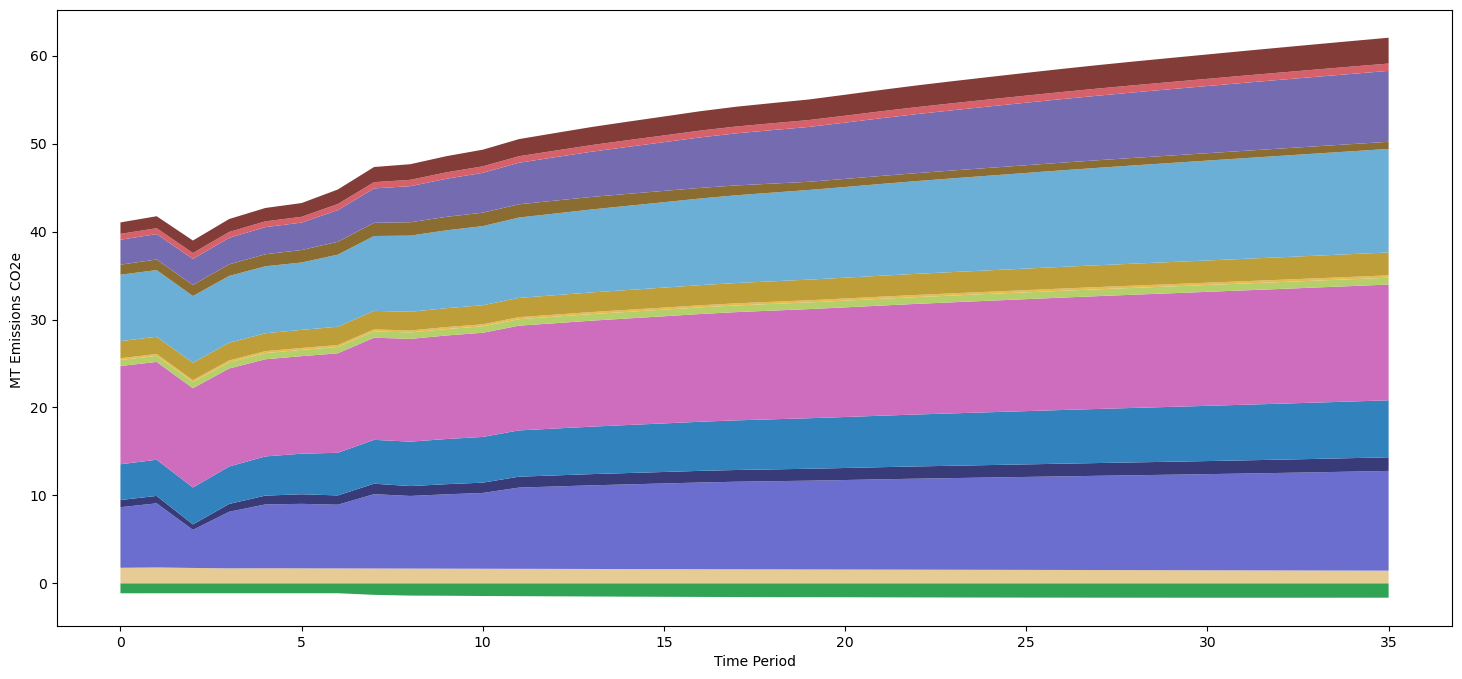

In [25]:

fig, ax = plt.subplots(figsize = (18, 8))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e ")

df_plot = df_out[
    df_out[ssp.key_primary].isin([0])
]


fields = matt.get_all_subsector_emission_total_fields()#[x for x in df_out.columns if (x.startswith("emission_co2e_subsector_total"))]
dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

fig, ax = spu.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict_format,
    field_x = "time_period",
    figtuple = (fig, ax),
)



# Export Wide File

In [26]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)


all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)




df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)



# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(dir_pkg, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        print(f"Warning: Table {tab} returned None.")


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

In [27]:
# Getting the directory where the outputs are stored
ssp.file_struct.dir_out

'/home/fabian_fuentes/anaconda3/envs/ssp2/lib/python3.11/site-packages/sisepuede/out'